In [1]:
%%time
import datetime as dt
import sys
import os

import scipy as sp
import numpy as np
import pandas as pd

####################
import geopandas
import shapely
from shapely.geometry import Point, Polygon, MultiPolygon
import shapely.ops as shp_ops
import shapely.wkt as wkt
import descartes
#import contextily as ctx
#######################

from IPython.display import display, HTML

import fastparquet

import matplotli as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

CPU times: user 779 ms, sys: 131 ms, total: 910 ms
Wall time: 1.14 s


In [2]:
%%time
files = ['trip_involving_astoria_inside_astoria0_tot.parq',
        'trip_involving_astoria_from_manhattan0_tot.parq',
        'trip_involving_astoria_to_manhattan0_tot.parq']

pf0 = fastparquet.ParquetFile(files[0])
df_inside_astoria = pf0.to_pandas()
print('done.')

pf1 = fastparquet.ParquetFile(files[1])
df_from_manhattan = pf1.to_pandas()
print('done.')

pf2 = fastparquet.ParquetFile(files[2])
df_to_manhattan = pf2.to_pandas()
print('done.')


done.
done.
done.
CPU times: user 6.5 s, sys: 883 ms, total: 7.39 s
Wall time: 10.5 s


In [198]:
%%time
cols_to_consider = ['pickup_datetime', 'dropoff_datetime', 'psgr_count', 'distance', 'fare', 'pickup_lng', 'cost',
                    'pickup_lat', 'dropoff_lng', 'dropoff_lat', 'filter', 'time_of_day', 'wkdy', 'loc_type']

cols_to_analyze = ['psgr_count', 'fare', 'filter', 'time_of_day', 'wkdy', 'cost']

locs = [' from Astoria to Manhattan', 'from Manhattan to Astoria',
       'neither from or to Astoria', 'within Astoria']



nyc_latitude = 40.730610
nyc_longitude = -73.935242

lng_to_mile = 52.34765958223438
lat_to_mile = 69.04799987565435

mile_to_lng = 1./lng_to_mile
mile_to_lat = 1./lat_to_mile


min_lng, max_lng = -74.05753568206349, -73.8919399449069
min_lat, max_lat = 40.673110890352014, 40.88884410240033
lng0, lat0 = -74.057535, 40.673110

def geo_to_mile(lng, lat):
    x = (lng - nyc_longitude) * lng_to_mile
    y = (lat - nyc_latitude) * lat_to_mile
    return x, y



CPU times: user 15 µs, sys: 1e+03 ns, total: 16 µs
Wall time: 22.2 µs


In [209]:
%%time
filename = 'trip_involving_astoria20'
months = ['15-07', '15-08', '15-09', '15-10', '15-11', '15-12', '16-01', '16-02', '16-03',
         '16-04', '16-05', '16-06']
df_lst = []
for m in months:
    pf = fastparquet.ParquetFile(filename+m+'.parq')
    df_lst.append(pf.to_pandas())

df_tot = pd.concat(df_lst)
df_tot.drop(df_tot[df_tot['psgr_count'] == 0].index, inplace=True)


df_tot.loc[:,'pickup_x'], df_tot.loc[:,'pickup_y'] = geo_to_mile(df_tot['pickup_lng'], df_tot['pickup_lat'])
df_tot.loc[:,'dropoff_x'], df_tot.loc[:,'dropoff_y'] = geo_to_mile(df_tot['dropoff_lng'], df_tot['dropoff_lat'])


# Definig a grid value for the data:
# accepted x or y distance walk for pickup and dropoff in miles are 1/pick_grid and 1/drop_grid
pick_grid = 4
drop_grid = 2

df_tot.loc[:,'pick_grid_x'] = (df_tot.loc[:,'pickup_x']*pick_grid).astype(int)
df_tot.loc[:,'pick_grid_y'] = (df_tot.loc[:,'pickup_y']*pick_grid).astype(int)
df_tot.loc[:,'drop_grid_x'] = (df_tot.loc[:,'dropoff_x']*drop_grid).astype(int)
df_tot.loc[:,'drop_grid_y'] = (df_tot.loc[:,'dropoff_y']*drop_grid).astype(int)

min_pgrid_x = df_tot['pick_grid_x'].min()-1
min_pgrid_y = df_tot['pick_grid_y'].min()-1
min_dgrid_x = df_tot['drop_grid_x'].min()-1
min_dgrid_y = df_tot['drop_grid_y'].min()-1

df_tot['pick_grid_x'] -= min_pgrid_x
df_tot['pick_grid_y'] -= min_pgrid_y
df_tot['drop_grid_x'] -= min_dgrid_x
df_tot['drop_grid_y'] -= min_dgrid_y
df_tot.loc[:, 'duration'] = df_tot['dropoff_datetime'] - df_tot['pickup_datetime']
df_tot.drop(df_tot[df_tot['duration'] < np.timedelta64(1, 's')].index, inplace=True)

wait_time = 5
df_tot.loc[:, 'time_of_day'] = df_tot['pickup_datetime'].dt.round(freq='5min').dt.time
df_tot.loc[:, 'time'] = ((df_tot['pickup_datetime'].dt.minute + 60 * df_tot['pickup_datetime'].dt.hour)
                        /wait_time).fillna(9999).astype(int)

df_tot.loc[:, 'wkdy'] = df_tot['pickup_datetime'].dt.dayofweek
df_tot.loc[:, 'day'] = df_tot['pickup_datetime'].dt.dayofyear

df_tot.loc[:, 'cost'] = df_tot['fare']/df_tot['psgr_count']/(df_tot['duration']/np.timedelta64(1, 'm'))


df_tot.loc[:,'filter'] = (df_tot['pick_grid_x'].astype(str).str.zfill(3) + 
                          df_tot['pick_grid_y'].astype(str).str.zfill(3) +
                          df_tot['drop_grid_x'].astype(str).str.zfill(3) + 
                          df_tot['drop_grid_y'].astype(str).str.zfill(3) +
                          df_tot['time'].astype(str).str.zfill(4))
df_tot['filter']  = '1' + df_tot['filter']
df_tot['filter'] = df_tot['filter'].astype(int)

df_tot = df_tot.loc[df_tot['loc_type'] != locs[2], cols_to_consider]

df_tot.reset_index(drop=True, inplace=True)

#print(df_tot.columns.tolist())

display(df_tot.shape)
display(df_tot.head(10))
#display(min_pgrid_x)
#display(min_pgrid_y)
#display(min_dgrid_x)
#display(min_dgrid_y)
#display(df_tot.describe())

(1750883, 14)

,pickup_datetime,dropoff_datetime,psgr_count,distance,fare,pickup_lng,cost,pickup_lat,dropoff_lng,dropoff_lat,filter,time_of_day,wkdy,loc_type
0,2015-07-01 00:00:22,2015-07-01 00:10:43,1,1.099609,6.0,-73.912430,0.579710,40.769810,-73.920334,40.757442,10220190100080000,00:00:00,2.0,within Astoria
1,2015-07-01 00:01:48,2015-07-01 00:08:51,1,5.699219,19.0,-73.987122,2.695035,40.733131,-73.924393,40.765877,10080090100090000,00:00:00,2.0,from Manhattan to Astoria
2,2015-07-01 00:03:33,2015-07-01 00:07:33,1,4.519531,19.5,-73.978584,4.875000,40.755344,-73.914940,40.757053,10090150110080000,00:05:00,2.0,from Manhattan to Astoria
3,2015-07-01 00:07:00,2015-07-01 00:09:53,1,4.718750,17.5,-73.983139,6.069364,40.766041,-73.921959,40.771118,10080180100100001,00:05:00,2.0,from Manhattan to Astoria
4,2015-07-01 00:05:53,2015-07-01 00:11:03,1,3.400391,15.5,-73.957031,3.000000,40.770668,-73.920921,40.755230,10140200100080001,00:05:00,2.0,from Manhattan to Astoria
5,2015-07-01 00:05:42,2015-07-01 00:14:52,1,6.089844,21.0,-74.004585,2.290909,40.737698,-73.931740,40.765060,10040100090090001,00:05:00,2.0,from Manhattan to Astoria
6,2015-07-01 00:19:33,2015-07-01 00:20:40,1,5.898438,24.5,-74.001732,21.940299,40.741104,-73.920944,40.755226,10050110100080003,00:20:00,2.0,from Manhattan to Astoria
7,2015-07-01 00:14:55,2015-07-01 00:22:57,2,5.500000,22.5,-73.984932,1.400415,40.751850,-73.915031,40.757004,10080140110080002,00:15:00,2.0,from Manhattan to Astoria
8,2015-07-01 00:19:08,2015-07-01 00:25:18,1,5.839844,23.0,-73.984825,3.729730,40.748081,-73.918594,40.765553,10080130100090003,00:20:00,2.0,from Manhattan to Astoria
9,2015-07-01 00:07:37,2015-07-01 00:26:06,2,6.699219,23.5,-73.998672,0.635708,40.729740,-73.920753,40.766575,10050090100090001,00:10:00,2.0,from Manhattan to Astoria


CPU times: user 35.7 s, sys: 8.31 s, total: 44.1 s
Wall time: 41.9 s


In [214]:
%%time

col_params = ['time_of_day', 'fare', 'cost', 'psgr_count', 'filter']
col_agg = dict()
col_agg['psgr_count'] = ['sum', 'count']
col_agg['cost'] = ['mean', 'sum']

result_col = ['time_idx', 'time', 'avg_agg_all', 'avg_psgr_per_agg_all', 'avg_agg_cost_all', 'total_agg_cost_all',
              'avg_agg_inside', 'avg_psgr_per_agg_inside', 'avg_agg_cost_inside', 'total_agg_cost_inside',
              'avg_agg_to_ast', 'avg_psgr_per_agg_to_ast', 'avg_agg_cost_to_ast', 'total_agg_cost_to_ast',
              'avg_agg_from_ast', 'avg_psgr_per_agg_from_ast', 'avg_agg_cost_from_ast', 'total_agg_cost_from_ast']
#col_agg = ['mean', 'count', 'sum']

# Zones conditions:
inside_astoria_cond = (df_tot['loc_type'] == locs[3])
to_astoria_cond = (df_tot['loc_type'] == locs[1])
from_astoria_cond = (df_tot['loc_type'] == locs[0])


# Time conditions:
day_avg_cond = True
is_weekday = (df_tot['wkdy'] < 5)
is_weekend = (df_tot['wkdy'] >= 5)
is_summer = ((df_tot['pickup_datetime'].dt.month > 5) & (df_tot['pickup_datetime'].dt.month < 9))
is_january = (df_tot['pickup_datetime'].dt.month == 1)
is_spring = ((df_tot['pickup_datetime'].dt.month > 3) & (df_tot['pickup_datetime'].dt.month < 6))
is_fall = ((df_tot['pickup_datetime'].dt.month > 8) & (df_tot['pickup_datetime'].dt.month < 12))

custom_date = dt.datetime.strptime('2016-01-01', '%Y-%m-%d')
index = pd.date_range(todays_date, periods=288, freq='5min')
df_result = pd.DataFrame(columns=result_col)
df_result['time'] = index
df_result['time_idx'] = index.time
df_result.set_index('time_idx', inplace=True)

g0_all = df_tot.loc[:, col_params].groupby('time_of_day')

for time, group in g0_all:
    g_all = group.groupby('filter').agg(col_agg)
    cond = g_all['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_all'] = g_all[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_all'] = g_all[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_all'] = g_all[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_all'] = g_all[cond]['cost']['sum'].mean()

print('1 out of 4')

g0_inside = df_tot.loc[inside_astoria_cond, col_params].groupby('time_of_day')
for time, group in g0_inside:
    g_inside = group.groupby('filter').agg(col_agg)
    cond = g_inside['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_inside'] = g_inside[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_inside'] = g_inside[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_inside'] = g_inside[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_inside'] = g_inside[cond]['cost']['sum'].mean()
    #df_result['psgr_sum']
    #display(g2[g2['psgr_count']['count'] > 1].shape)
    #display(g2[g2['psgr_count']['count'] > 1].head())
    #df_result['within_Astoria'] = g2[]
    
print('2 out of 4')

g0_from_ast = df_tot.loc[from_astoria_cond, col_params].groupby('time_of_day')

for time, group in g0_from_ast:
    g_from_ast = group.groupby('filter').agg(col_agg)
    cond = g_from_ast['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_from_ast'] = g_from_ast[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_from_ast'] = g_from_ast[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_from_ast'] = g_from_ast[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_from_ast'] = g_from_ast[cond]['cost']['sum'].mean()

print('3 out of 4')
    
g0_to_ast = df_tot.loc[to_astoria_cond, col_params].groupby('time_of_day')

for time, group in g0_to_ast:
    g_to_ast = group.groupby('filter').agg(col_agg)
    cond = g_to_ast['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_to_ast'] = g_to_ast[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_to_ast'] = g_to_ast[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_to_ast'] = g_to_ast[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_to_ast'] = g_to_ast[cond]['cost']['sum'].mean()
print('4 out of 4')
df_result.set_index('time', inplace=True)
#df_result.fillna(0, inplace=True)
display(df_result.head())

1 out of 4
2 out of 4
3 out of 4
4 out of 4


,avg_agg_all,avg_psgr_per_agg_all,avg_agg_cost_all,total_agg_cost_all,avg_agg_inside,avg_psgr_per_agg_inside,avg_agg_cost_inside,total_agg_cost_inside,avg_agg_to_ast,avg_psgr_per_agg_to_ast,avg_agg_cost_to_ast,total_agg_cost_to_ast,avg_agg_from_ast,avg_psgr_per_agg_from_ast,avg_agg_cost_from_ast,total_agg_cost_from_ast
time,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,5.18614,8.26931,2.23718,11.6051,6.24259,10.0296,2.57312,14.7476,2.25532,3.70213,2.10238,4.59364,2.25287,3.21839,0.876407,1.97864
2016-01-01 00:05:00,5.40283,8.54453,2.16796,11.6213,6.46612,10.3062,2.31287,14.2912,2.2449,3.2449,2.99721,6.31691,2.23684,3.35526,0.930424,2.04349
2016-01-01 00:10:00,5.31417,8.54004,3.49441,12.9988,6.24332,10.0829,4.15511,16.0699,2.18182,3.63636,2.18709,4.6047,2.25,3.2875,0.945532,2.10131
2016-01-01 00:15:00,4.98523,8.18987,2.50489,10.4577,5.84765,9.5928,2.9398,12.9556,2.09756,3.7561,1.53236,3.25208,2.27778,3.58333,0.879279,2.01079
2016-01-01 00:20:00,5.29661,8.20763,1.85922,9.99169,6.26593,9.76731,1.94062,12.0392,2.0303,3.12121,1.84622,3.74781,2.16883,3.12987,1.49034,3.13564


CPU times: user 40.7 s, sys: 855 ms, total: 41.5 s
Wall time: 44.7 s


CPU times: user 896 ms, sys: 83.8 ms, total: 980 ms
Wall time: 1.58 s


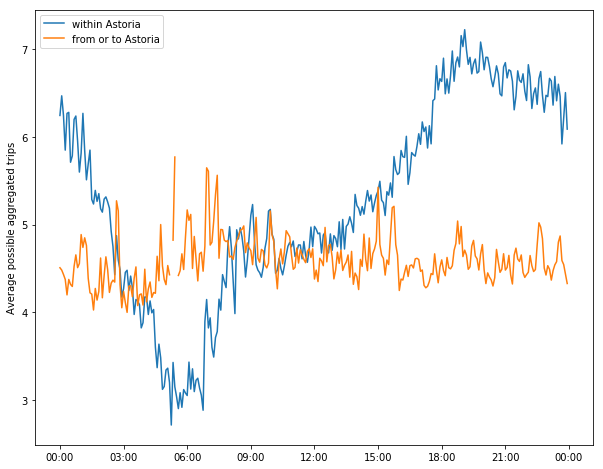

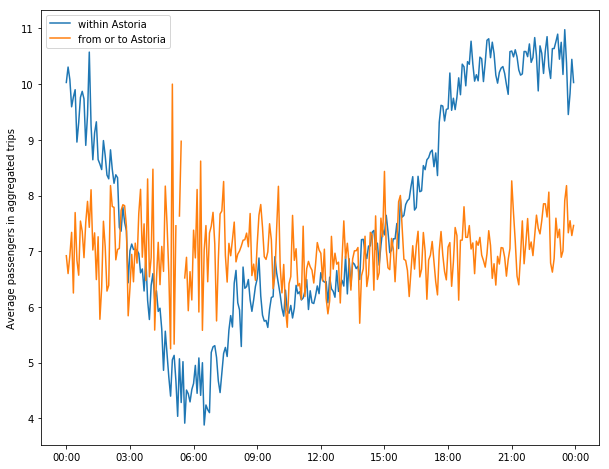

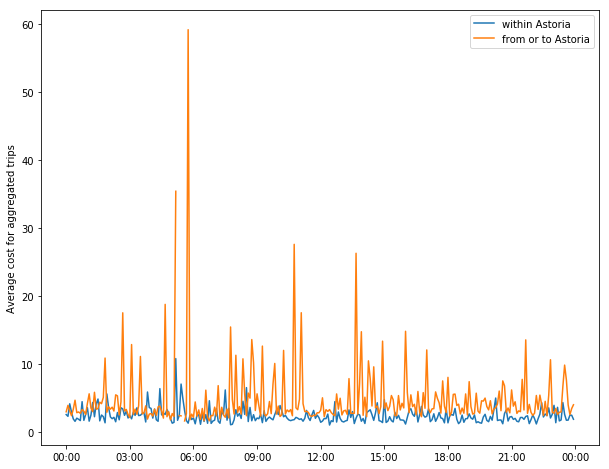

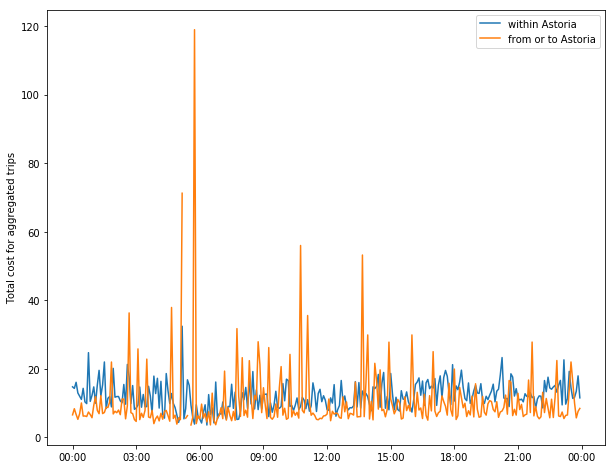

In [252]:
%%time

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_result['avg_agg_inside'], label='within Astoria')
ax.plot(df_result['avg_agg_from_ast']+df_result['avg_agg_to_ast'], label='from or to Astoria')

ax.set_ylabel('Average possible aggregated trips')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax.legend()
plt.savefig('Average_possible_aggregated_trips.png')

fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(df_result['avg_psgr_per_agg_inside'], label='within Astoria')
ax1.plot(df_result['avg_psgr_per_agg_from_ast']+df_result['avg_psgr_per_agg_to_ast'], label='from or to Astoria')

ax1.set_ylabel('Average passengers in aggregated trips')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax1.legend()
plt.savefig('Average_passengers_in_aggregated_trips.png')

fig11 = plt.figure(figsize=(10,8))
ax11 = fig11.add_subplot(1, 1, 1)
ax11.plot(df_result['avg_agg_cost_inside'], label='within Astoria')
ax11.plot(df_result['avg_agg_cost_from_ast']+df_result['avg_agg_cost_to_ast'], label='from or to Astoria')

ax11.set_ylabel('Average cost for aggregated trips')
ax11.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax11.legend()
plt.savefig('Average_cost_for_aggregated_trips.png')

fig111 = plt.figure(figsize=(10,8))
ax111 = fig111.add_subplot(1, 1, 1)
ax111.plot(df_result['total_agg_cost_inside'], label='within Astoria')
ax111.plot(df_result['total_agg_cost_from_ast']+df_result['total_agg_cost_to_ast'], label='from or to Astoria')

ax111.set_ylabel('Total cost for aggregated trips')
ax111.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax111.legend()
plt.savefig('Total_cost_for_aggregated_trips.png')





1 out of 4
2 out of 4
3 out of 4
4 out of 4
CPU times: user 38.9 s, sys: 683 ms, total: 39.6 s
Wall time: 47.9 s


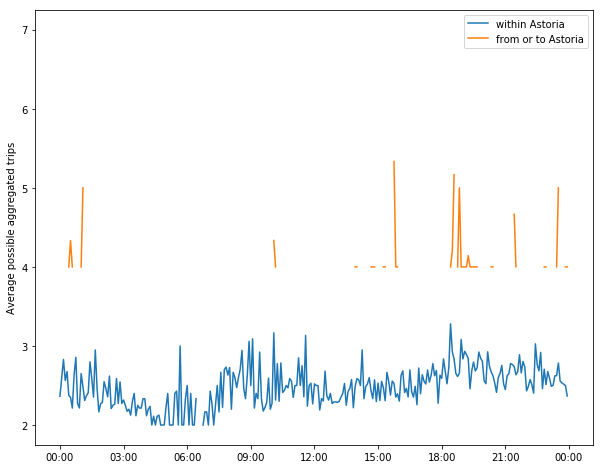

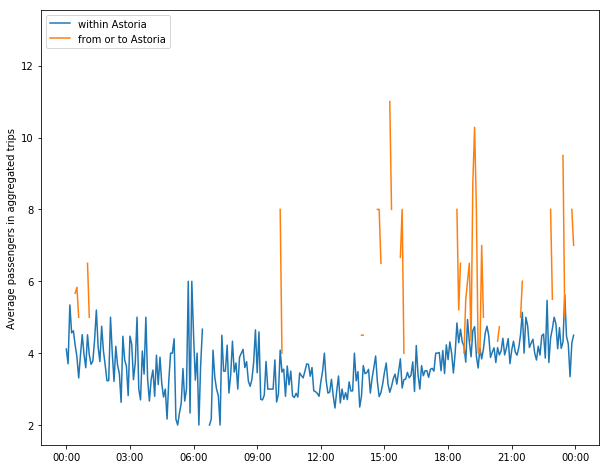

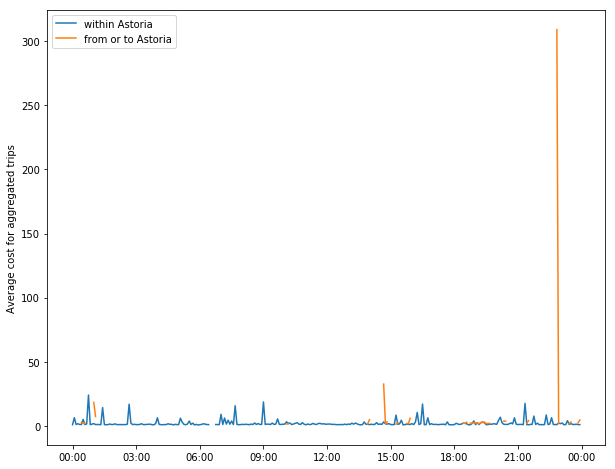

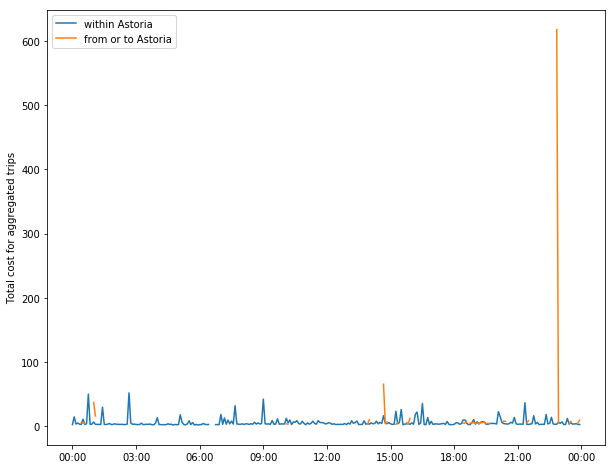

In [260]:
%%time
# Time conditions:
day_avg_cond = True
is_weekday = (df_tot['wkdy'] < 5)
is_weekend = (df_tot['wkdy'] >= 5)
is_summer = ((df_tot['pickup_datetime'].dt.month > 5) & (df_tot['pickup_datetime'].dt.month < 9))
is_january = (df_tot['pickup_datetime'].dt.month == 1)
is_spring = ((df_tot['pickup_datetime'].dt.month > 3) & (df_tot['pickup_datetime'].dt.month < 6))
is_fall = ((df_tot['pickup_datetime'].dt.month > 8) & (df_tot['pickup_datetime'].dt.month < 12))


df_result = pd.DataFrame(columns=result_col)
df_result['time'] = index
df_result['time_idx'] = index.time
df_result.set_index('time_idx', inplace=True)
cc =  q

g0_all = df_tot.loc[cc, col_params].groupby('time_of_day')

for time, group in g0_all:
    g_all = group.groupby('filter').agg(col_agg)
    cond = g_all['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_all'] = g_all[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_all'] = g_all[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_all'] = g_all[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_all'] = g_all[cond]['cost']['sum'].mean()

print('1 out of 4')

g0_inside = df_tot.loc[inside_astoria_cond & cc, col_params].groupby('time_of_day')
for time, group in g0_inside:
    g_inside = group.groupby('filter').agg(col_agg)
    cond = g_inside['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_inside'] = g_inside[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_inside'] = g_inside[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_inside'] = g_inside[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_inside'] = g_inside[cond]['cost']['sum'].mean()
    #df_result['psgr_sum']
    #display(g2[g2['psgr_count']['count'] > 1].shape)
    #display(g2[g2['psgr_count']['count'] > 1].head())
    #df_result['within_Astoria'] = g2[]
    
print('2 out of 4')

g0_from_ast = df_tot.loc[from_astoria_cond & cc, col_params].groupby('time_of_day')

for time, group in g0_from_ast:
    g_from_ast = group.groupby('filter').agg(col_agg)
    cond = g_from_ast['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_from_ast'] = g_from_ast[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_from_ast'] = g_from_ast[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_from_ast'] = g_from_ast[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_from_ast'] = g_from_ast[cond]['cost']['sum'].mean()

print('3 out of 4')
    
g0_to_ast = df_tot.loc[to_astoria_cond & cc, col_params].groupby('time_of_day')

for time, group in g0_to_ast:
    g_to_ast = group.groupby('filter').agg(col_agg)
    cond = g_to_ast['psgr_count']['count'] > 1
    df_result.loc[time, 'avg_agg_to_ast'] = g_to_ast[cond]['psgr_count']['count'].mean()
    df_result.loc[time, 'avg_psgr_per_agg_to_ast'] = g_to_ast[cond]['psgr_count']['sum'].mean()
    df_result.loc[time, 'avg_agg_cost_to_ast'] = g_to_ast[cond]['cost']['mean'].mean()
    df_result.loc[time, 'total_agg_cost_to_ast'] = g_to_ast[cond]['cost']['sum'].mean()
print('4 out of 4')
df_result.set_index('time', inplace=True)
#df_result.fillna(0, inplace=True)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(1, 1, 1)
ax.plot(df_result['avg_agg_inside'], label='within Astoria')
ax.plot(df_result['avg_agg_from_ast']+df_result['avg_agg_to_ast'], label='from or to Astoria')

ax.set_ylabel('Average possible aggregated trips')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax.legend()
plt.savefig('Average_possible_aggregated_trips.png')

fig1 = plt.figure(figsize=(10,8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(df_result['avg_psgr_per_agg_inside'], label='within Astoria')
ax1.plot(df_result['avg_psgr_per_agg_from_ast']+df_result['avg_psgr_per_agg_to_ast'], label='from or to Astoria')

ax1.set_ylabel('Average passengers in aggregated trips')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax1.legend()
plt.savefig('Average_passengers_in_aggregated_trips.png')

fig11 = plt.figure(figsize=(10,8))
ax11 = fig11.add_subplot(1, 1, 1)
ax11.plot(df_result['avg_agg_cost_inside'], label='within Astoria')
ax11.plot(df_result['avg_agg_cost_from_ast']+df_result['avg_agg_cost_to_ast'], label='from or to Astoria')

ax11.set_ylabel('Average cost for aggregated trips')
ax11.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax11.legend()
plt.savefig('Average_cost_for_aggregated_trips.png')

fig111 = plt.figure(figsize=(10,8))
ax111 = fig111.add_subplot(1, 1, 1)
ax111.plot(df_result['total_agg_cost_inside'], label='within Astoria')
ax111.plot(df_result['total_agg_cost_from_ast']+df_result['total_agg_cost_to_ast'], label='from or to Astoria')

ax111.set_ylabel('Total cost for aggregated trips')
ax111.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))     #optional formatting 
ax111.legend()
plt.savefig('Total_cost_for_aggregated_trips.png')
